In [0]:
# Importing the necessary libraries andPyspark instances.
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as py
import pandas as pd
spark = SparkSession.builder.appName("TitanicEDA").getOrCreate()

path = "/FileStore/tables/insurance-1.csv"
data = spark.read.csv(path, header=True, inferSchema=True)
#print(data)

In [0]:
# The below code is used to describe the entire dataset. From the below output we can see the, Count, Mean, Standard Deviation, Minimum and Maximum of each column. From the below output, we can see that the standard devivation of each numeric column is high except for children.
data.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+---------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|age_group|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+---------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|     1338|
|   mean| 39.20702541106129|  NULL|30.663396860986538|  1.0949177877429|  NULL|     NULL|13270.422265141257|     NULL|
| stddev|14.049960379216147|  NULL| 6.098186911679012|1.205492739781914|  NULL|     NULL|12110.011236693992|     NULL|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|    20-29|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801| Under 20|
+-------+------------------+------+-------------

In [0]:
#Missing Data - From the below output, we can confirm that there are no missing values in any of the provided column. The col function is a reference to the column and is generally preferred when performing operations on columns like selection, filtering and applying transformations.
from pyspark.sql.functions import count, when, isnan, col, avg
missing_data = data.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in data.columns])
display(missing_data)



age,sex,bmi,children,smoker,region,charges,age_group
0,0,0,0,0,0,0,0


In [0]:
# The below is the correlation between the numerical variables with the charges column (I considered it as the target column).
for i in data.columns: 
    if i not in ["sex", "charges","region","smoker"]:
        print("correlation between",i," and target charges = ")
        print(data.stat.corr(i,"charges"))
        

correlation between age  and target charges = 
0.299008193330648
correlation between bmi  and target charges = 
0.19834096883362903
correlation between children  and target charges = 
0.06799822684790492


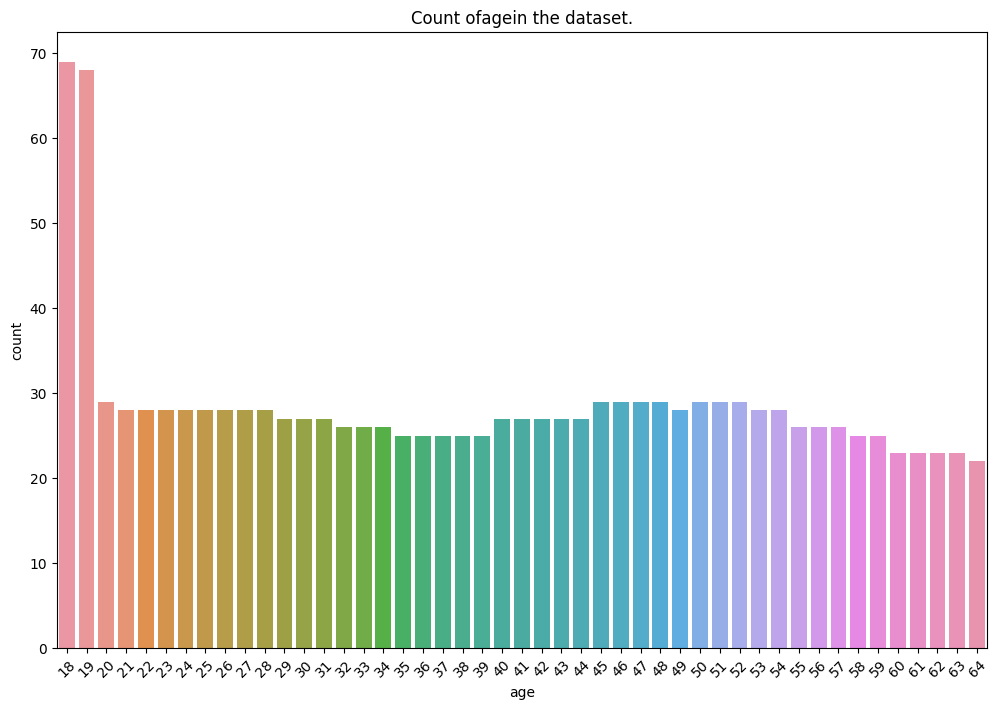

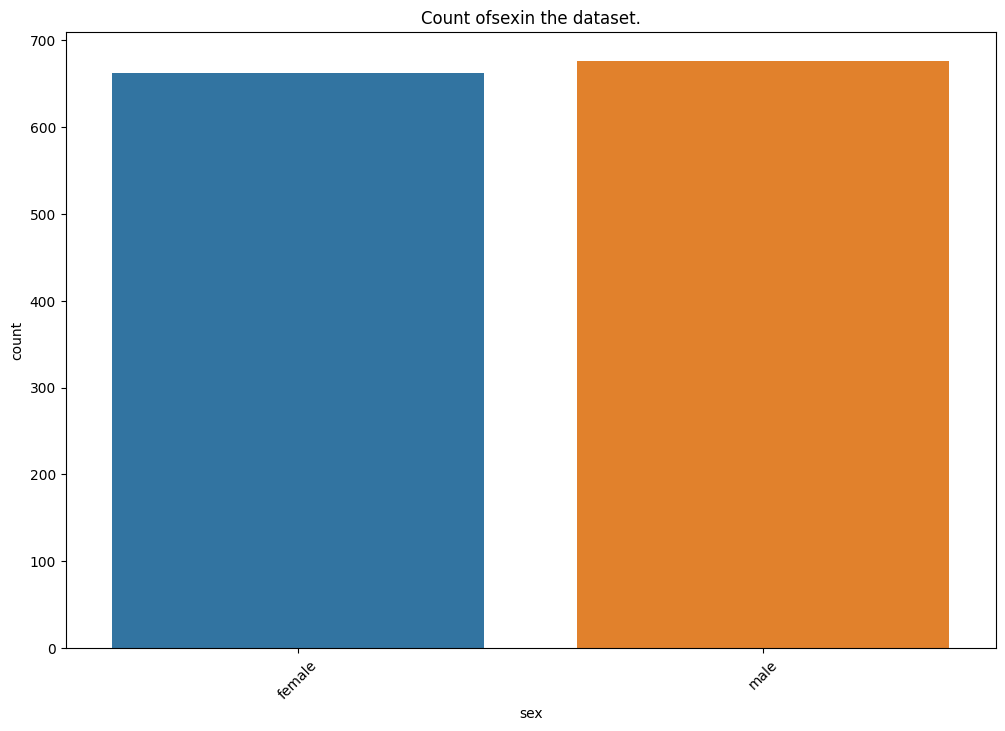

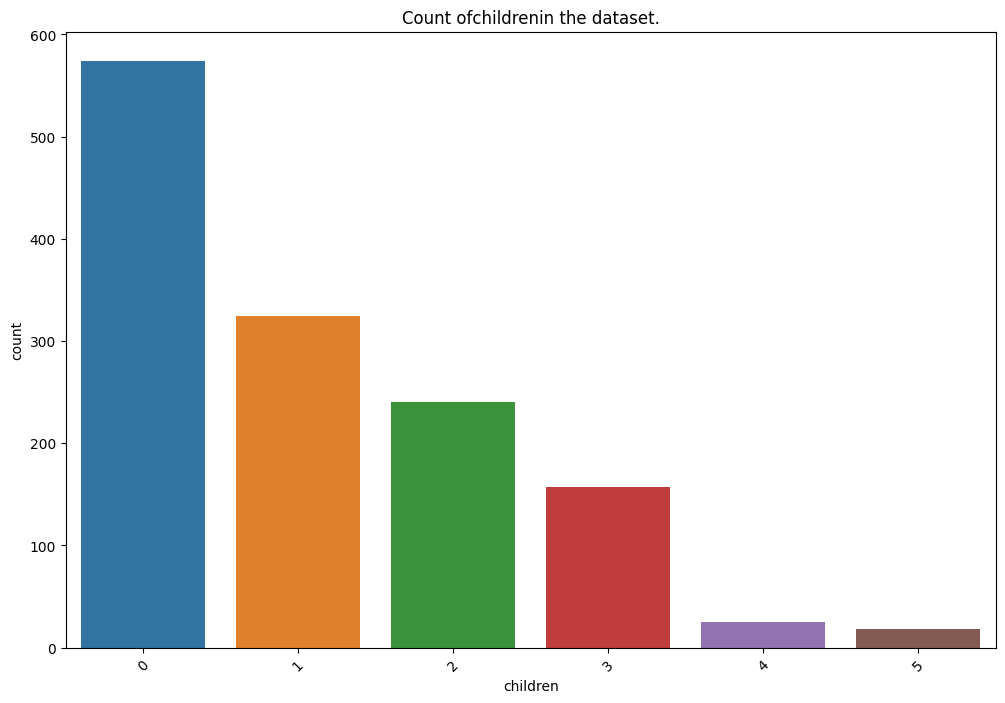

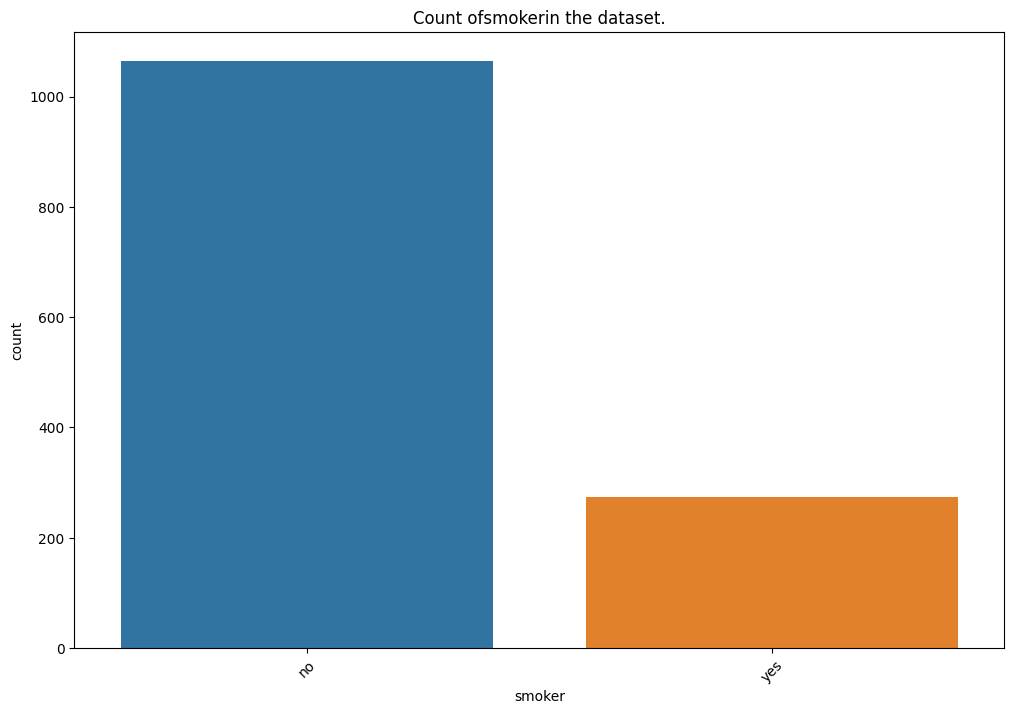

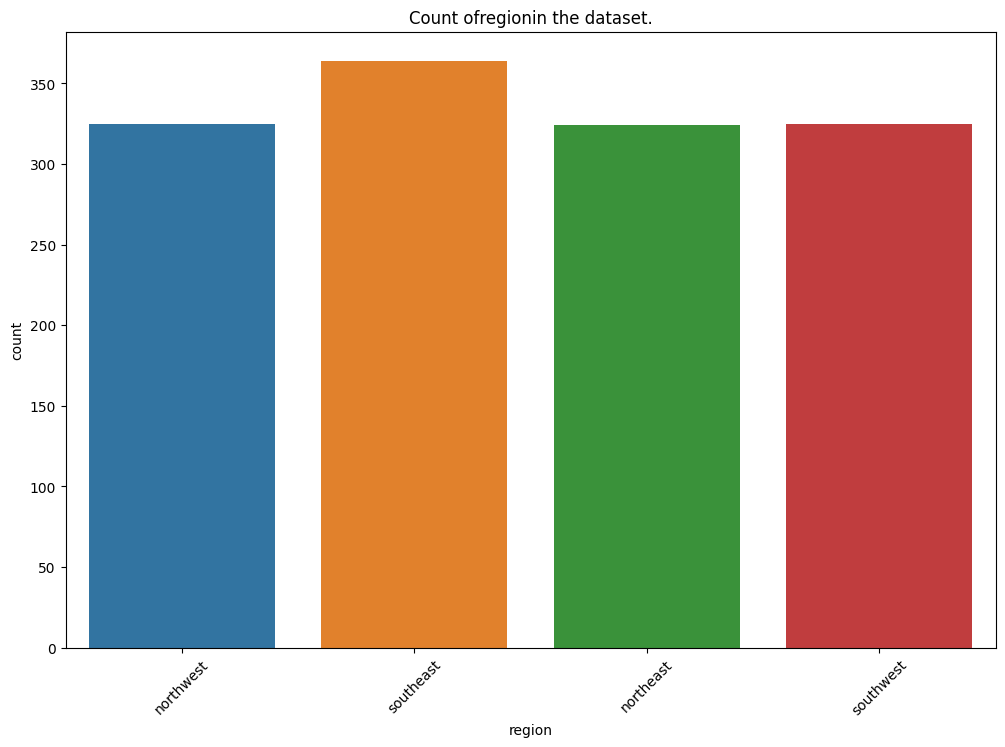

In [0]:
# From here, actual analysis begins and below charts are the counts data in each column seggregated according to the respective category. For instance, There are around 70 people with the age of 18 and 19. Rest are almost close to 30 per each age group.
# There are approximately the same femal and male of around 700 peiple each.
# The people with children count from 0 to 5 has been linearly decreased with highest being a little more than 550 members with 0 children to nearly 10-15 people with 5 children
# The count of non-smokers is just above 4 times the count of smokers which is almost 250.
# While, around 325 people are from NorthWest, NorthEast, SouthWest, there are more people from SouthEast (350+)
for i in data.columns:
    if i not in ["bmi","charges"]:
        d_c = data.groupBy(i).count()
        d_c = d_c.toPandas()
        #display(d_c)
        py.figure(figsize = (12,8))
        sns.barplot(x = d_c[i],y = d_c["count"],data = d_c)
        py.title("Count of "+ i +" in the dataset.")
        py.xticks(rotation = 45)
        py.show()


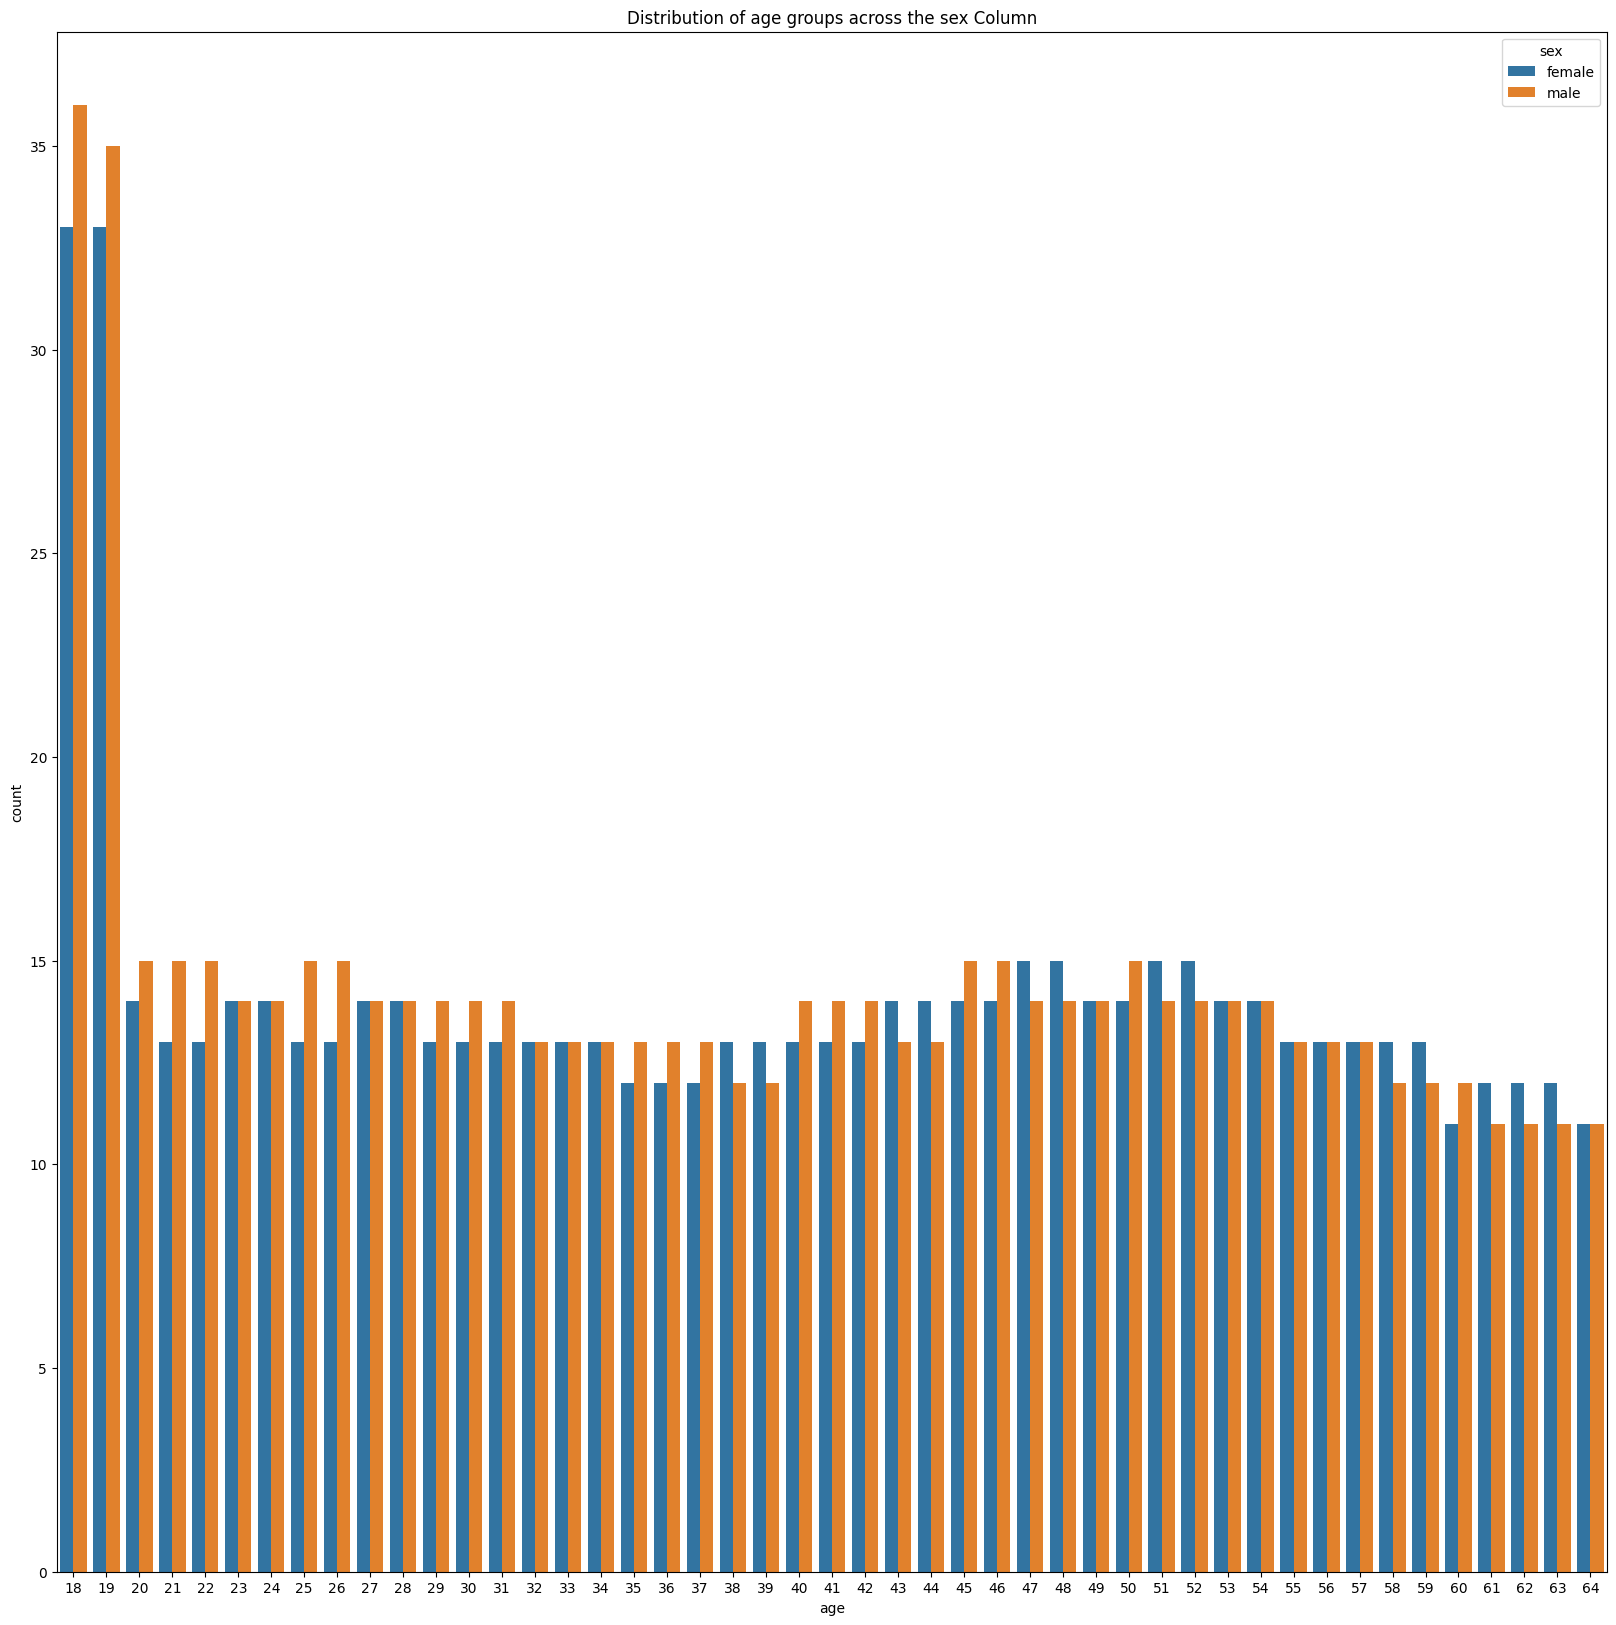

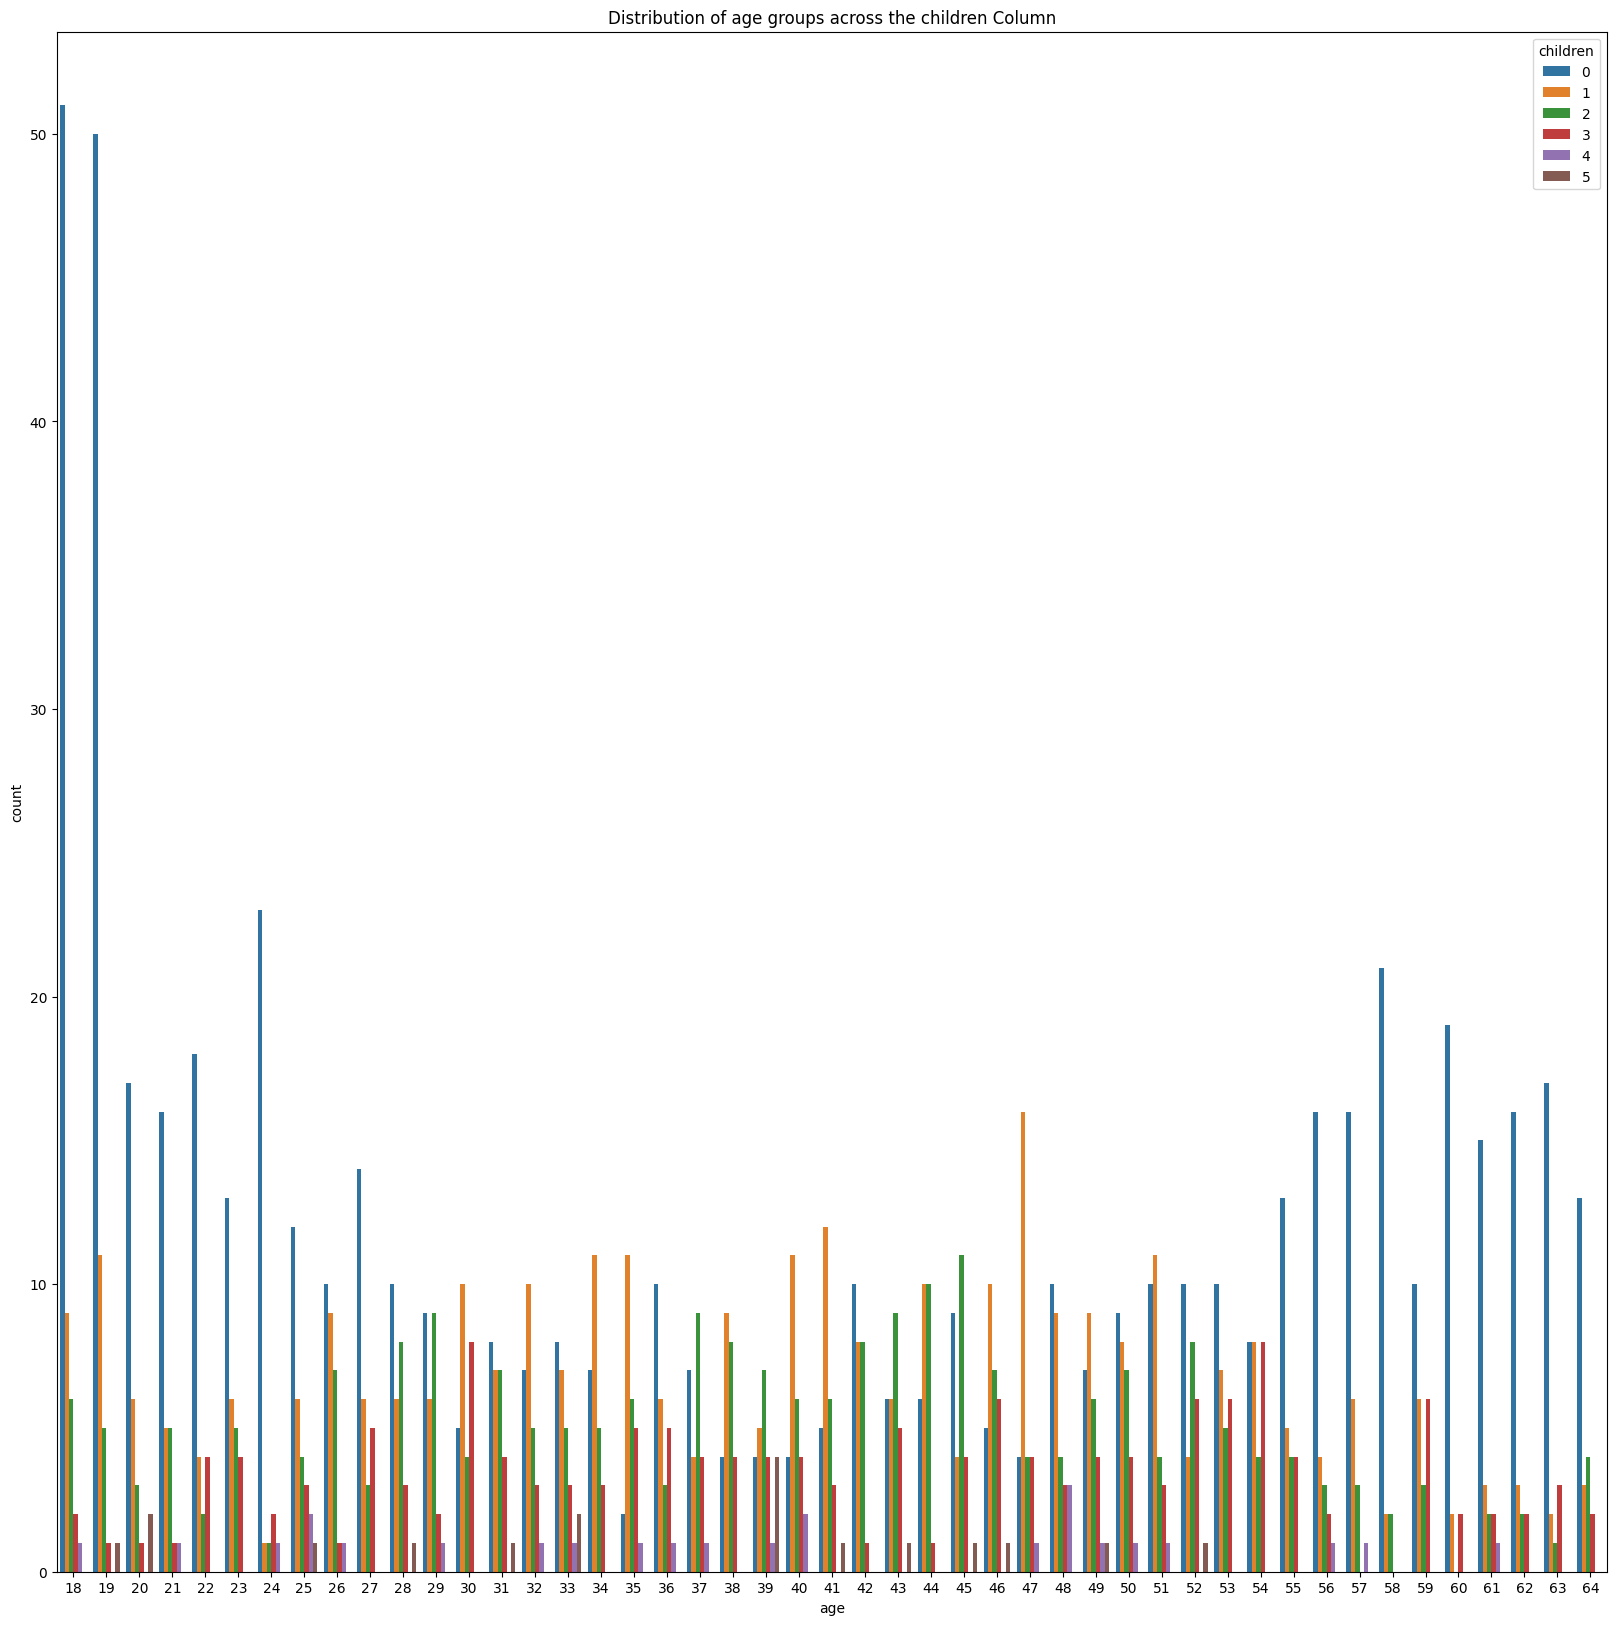

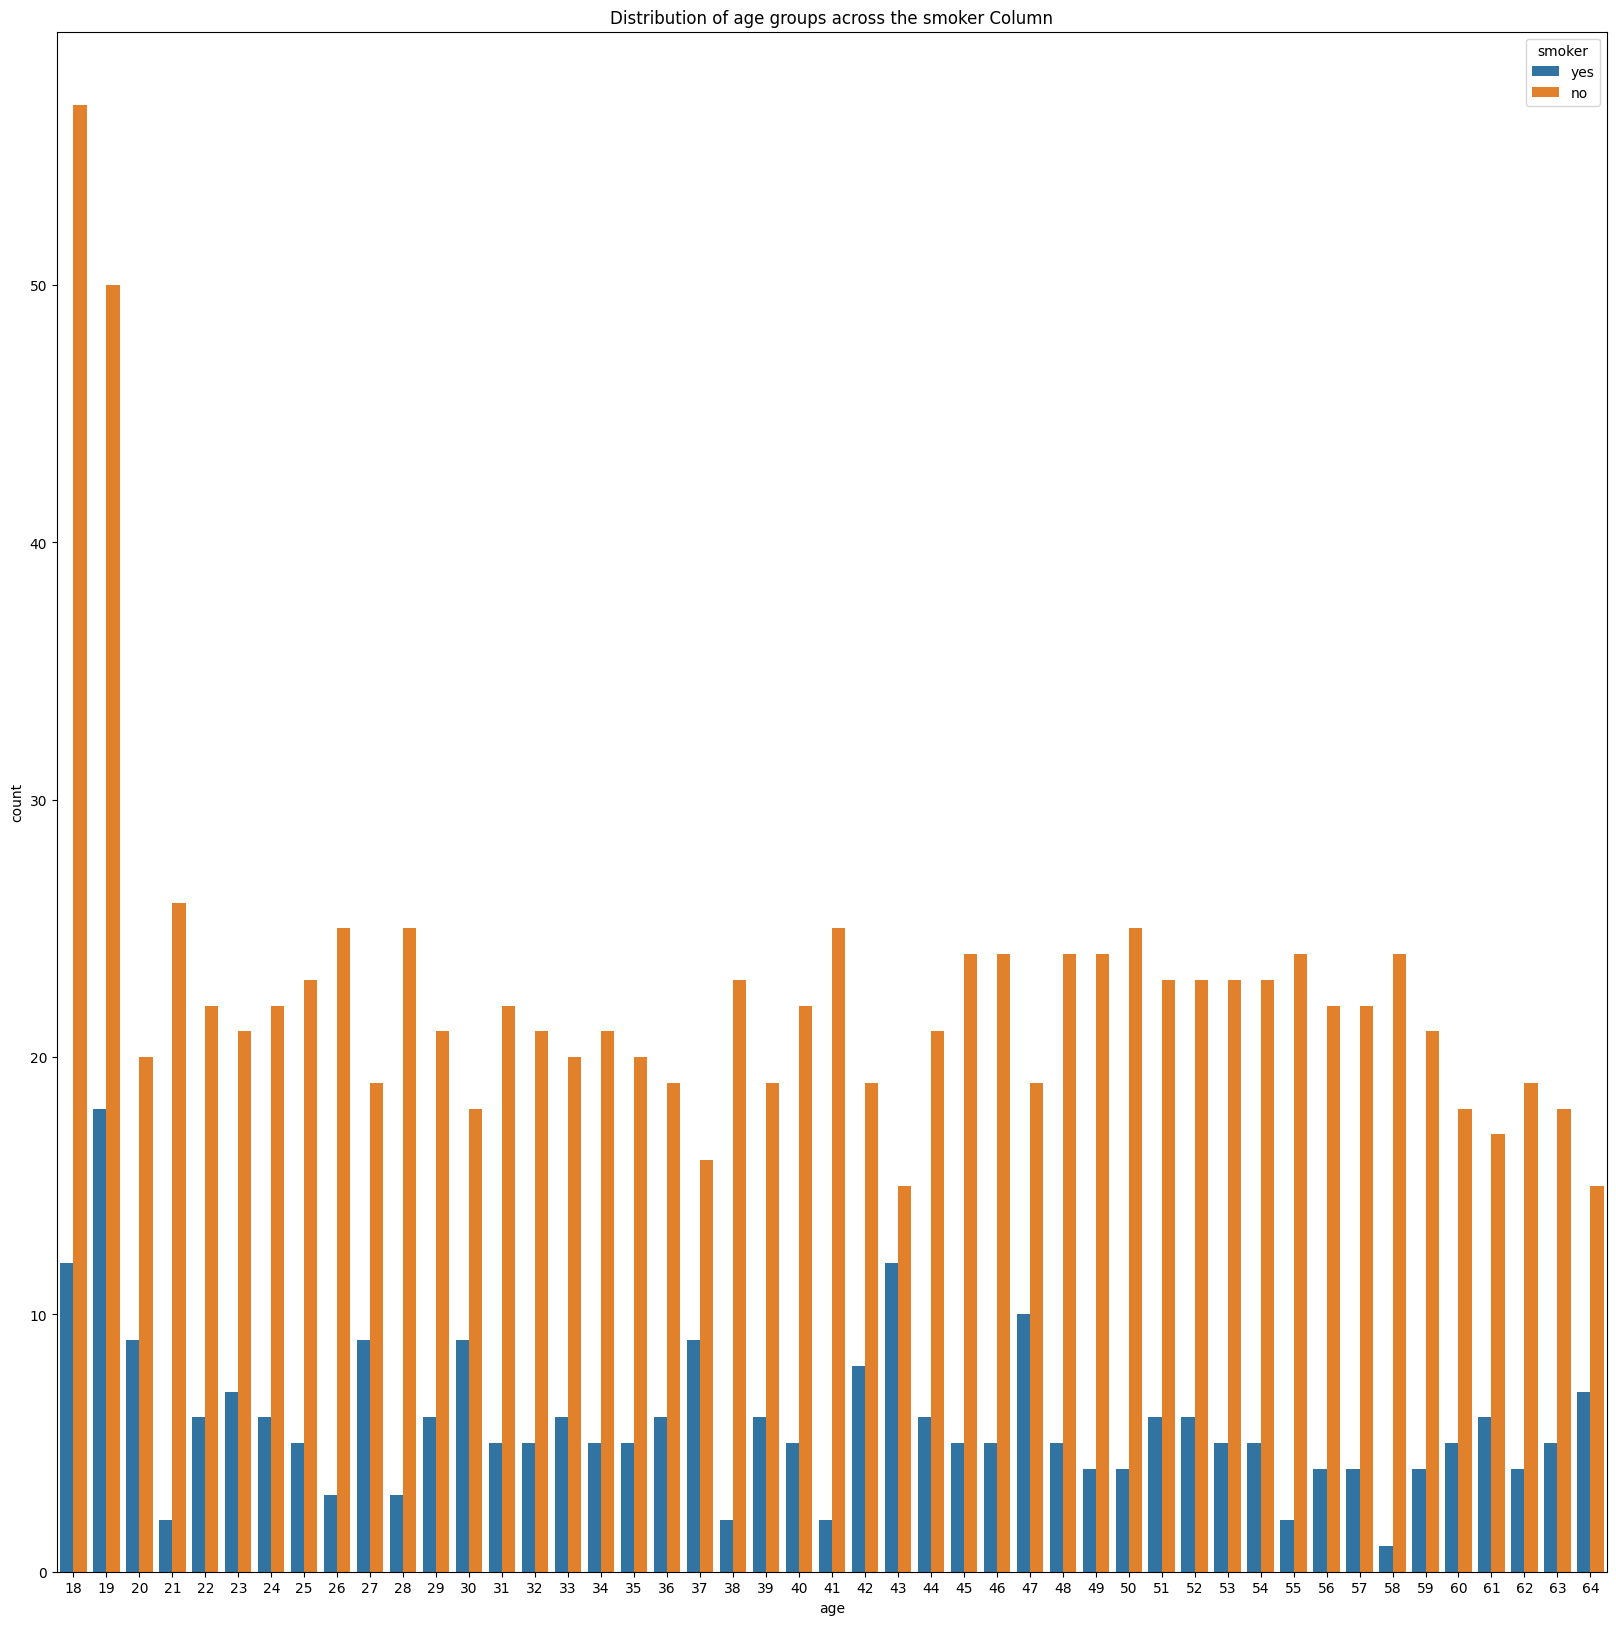

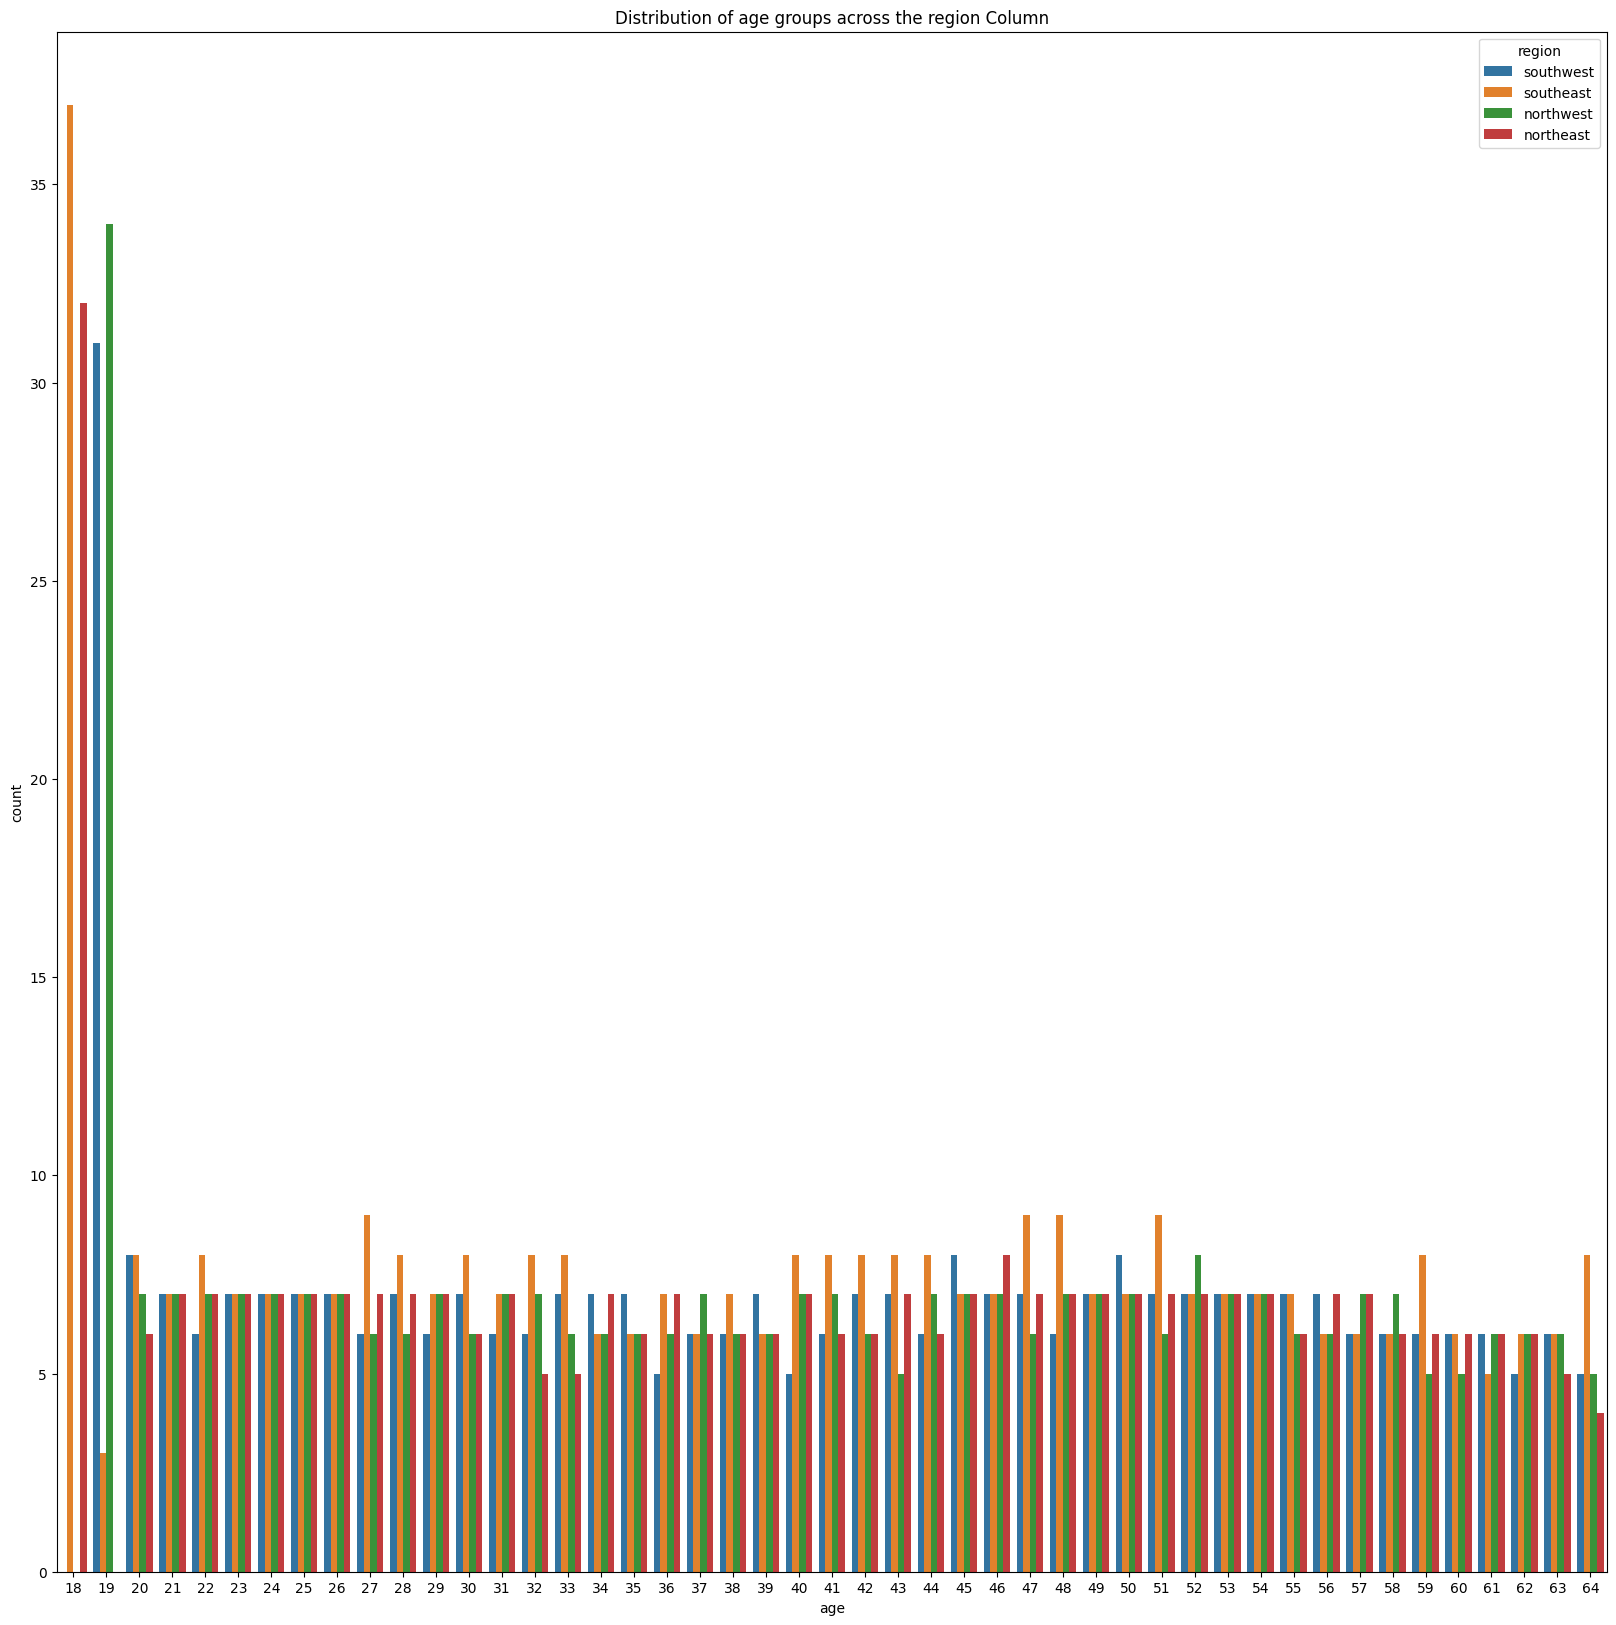

In [0]:
# Below is the distribution of age group across various field. From these graphs, we can understand the count of different age group people, their count according to their Gender, If they are smokers or not, number of childres and their region of residence.
for i in data.columns:
    if i not in ["age","bmi","charges","age_group"]:
        py.figure(figsize=(20,20))
        sns.countplot(data=data.toPandas(),x = 'age',hue=i)
        py.title("Distribution of age groups across the "+ i + " Column")
        py.show()

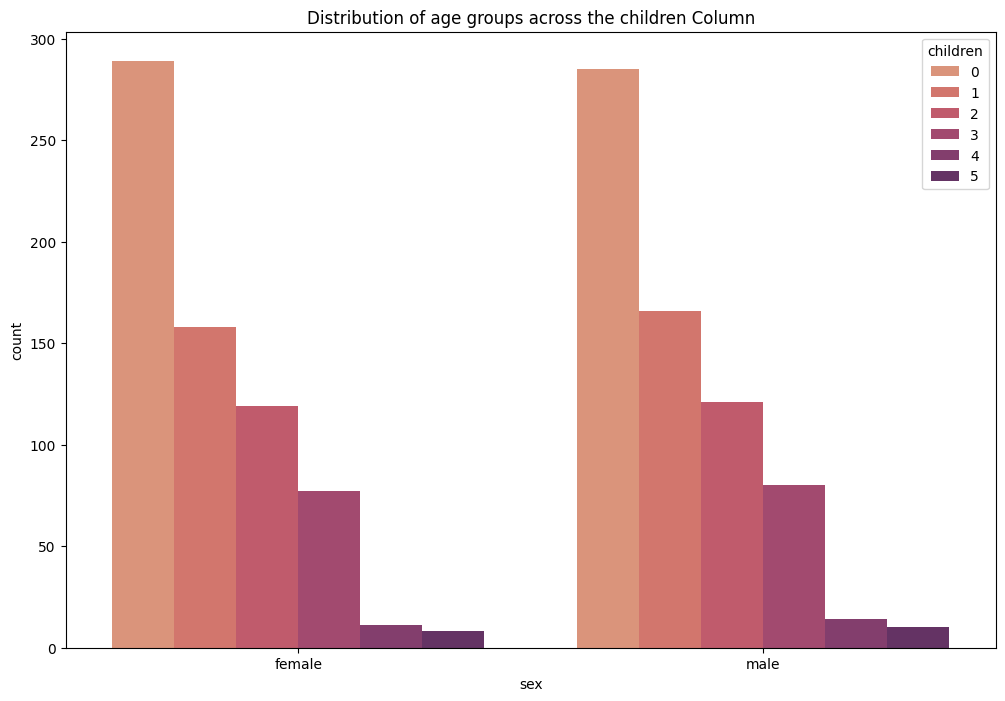

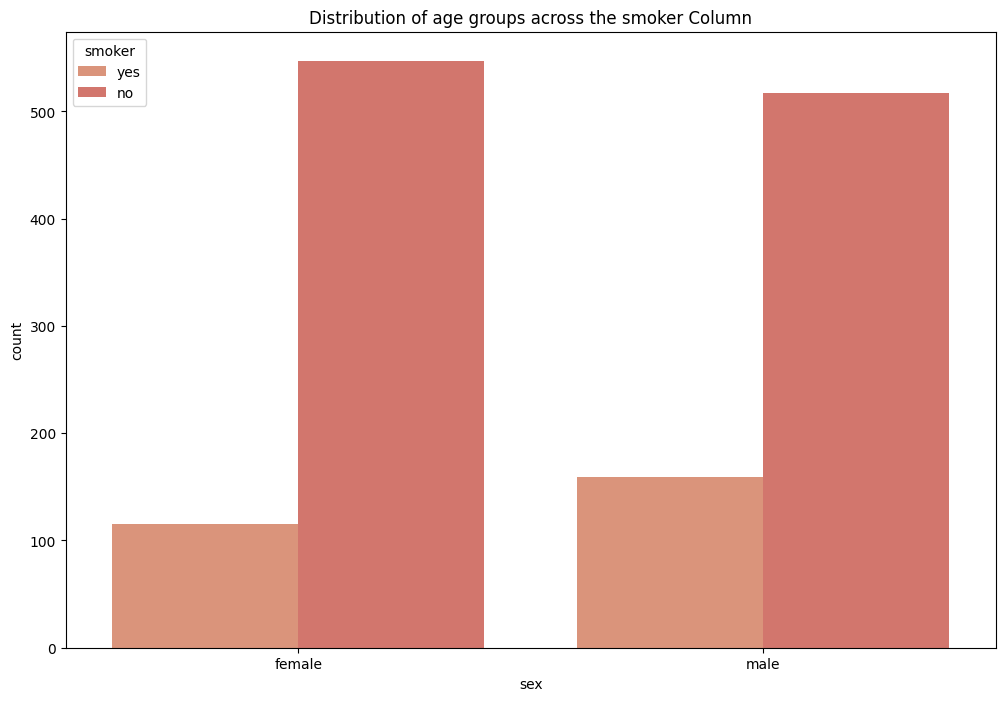

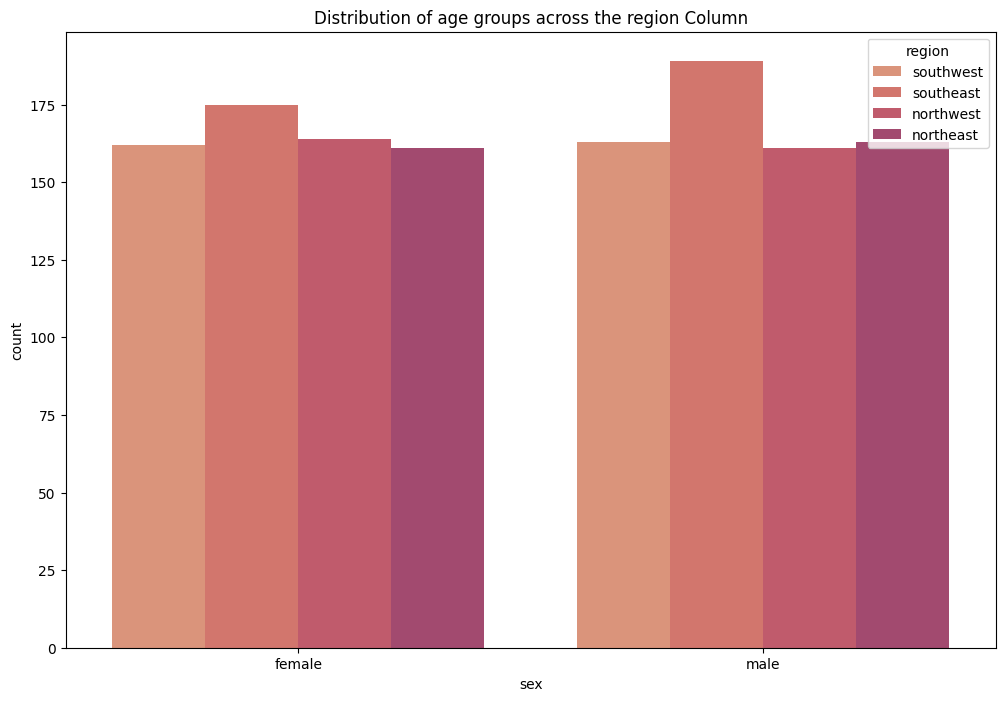

In [0]:
# The above analysis for age, is now applied for the Gender. One intruiging aspect is that the gender count in the number of children is exactly the same. Thus informing that the offsprings count is tallied.
for i in data.columns:
    if i not in ["age","bmi","charges","sex"]:
        py.figure(figsize=(12,8))
        sns.countplot(data=data.toPandas(),x = 'sex',hue=i,palette=sns.color_palette("flare"))
        py.title("Distribution of age groups across the "+ i + " Column")
        py.show()

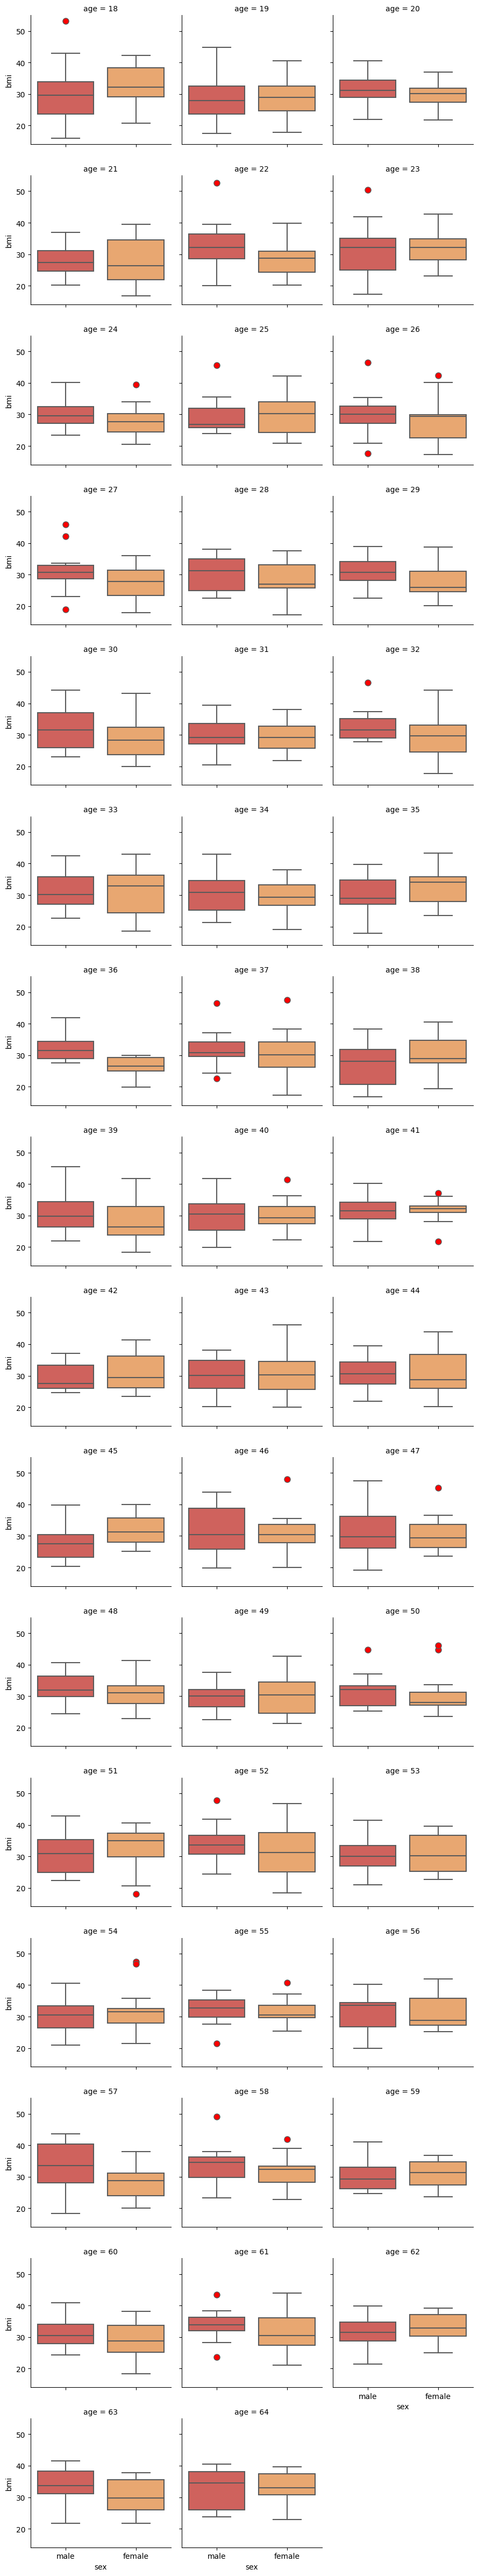

In [0]:
# Here, we can see the Body Mass Index for each age group divided by the gender column. The outliers are marked in the red dots.
pandas_data = data.toPandas()
bmi_age_gender = sns.FacetGrid(pandas_data,col="age",col_wrap=3)
bmi_age_gender.map(sns.boxplot,"sex","bmi",order = ["male","female"],palette = sns.color_palette("Spectral"),flierprops=dict(markerfacecolor="red", marker="o", markersize=8))


In [0]:
# From the above graph, we can see that there is no significant difference in BMI as age increases. To check if age affects BMI, for this dataset, we will check the correlation between these two columns now..Since the correlation is small and positive, we cannot say that the age affects the BMI.
data.stat.corr("age","bmi")


0.1092718815485351

In [0]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col
data = data.withColumn("age_group", F.when(col("age") < 20, "Under 20").otherwise(
                                 F.when((col("age") >= 20) & (col("age") < 30), "20-29").otherwise(
                                 F.when((col("age") >= 30) & (col("age") < 40), "30-39").otherwise(
                                 F.when((col("age") >= 40) & (col("age") < 50), "40-49").otherwise(
                                 F.when((col("age") >= 50) & (col("age") < 60), "50-59").otherwise(
                                 F.when(col("age") >= 60, "60 and above").otherwise("Unknown")))))))


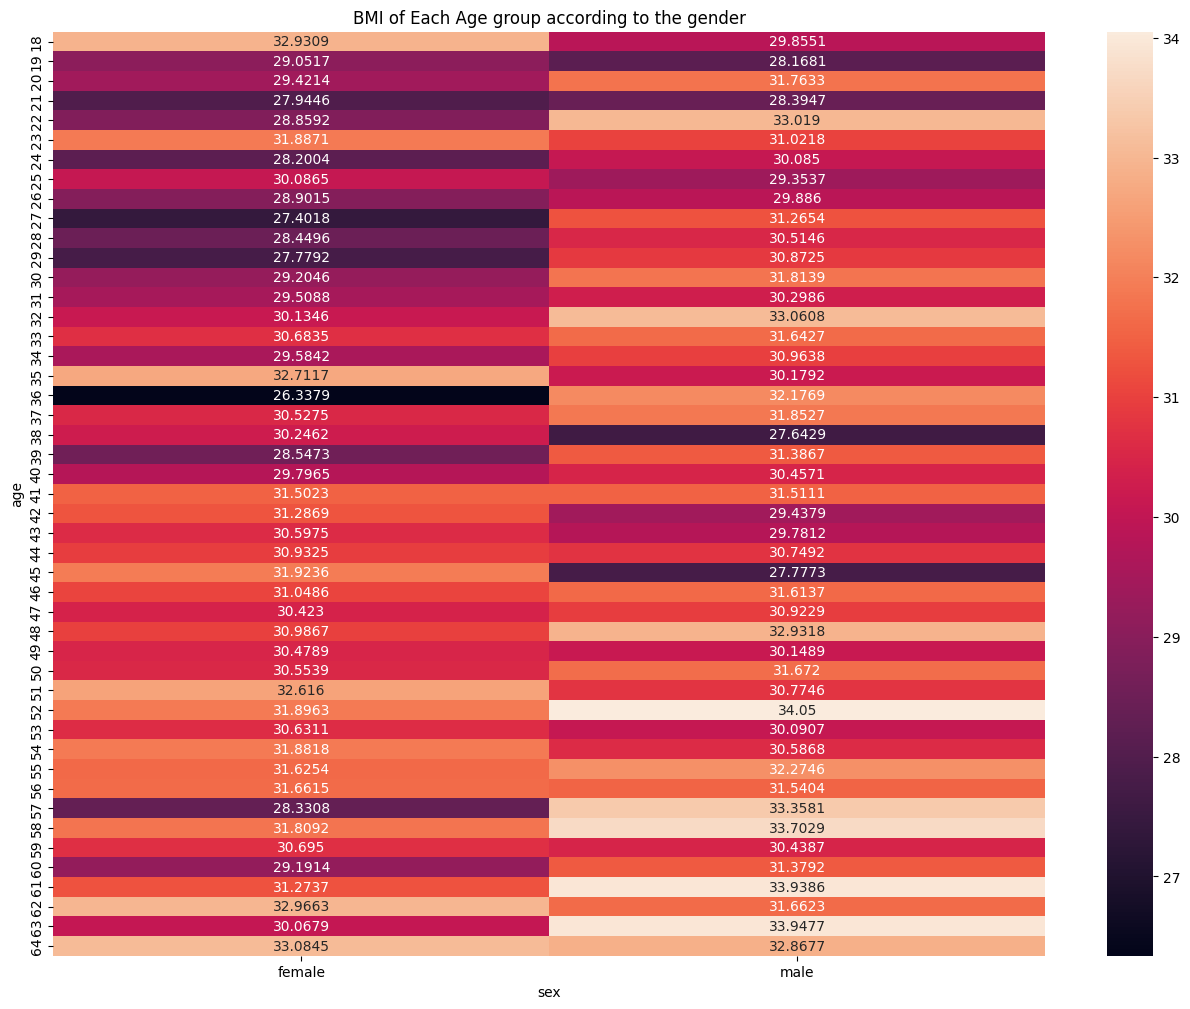

In [0]:
# This is just a heatmap representation of the BMI of the genders according to their age. The displayed values are the mean values.
new_pandas = data.toPandas()
heat = new_pandas.pivot_table(index='age', columns='sex',values = 'bmi', fill_value=0)
py.figure(figsize = (16,12))
sns.heatmap(heat, annot=True, fmt='g')
py.title("BMI of Each Age group according to the gender")
py.show()

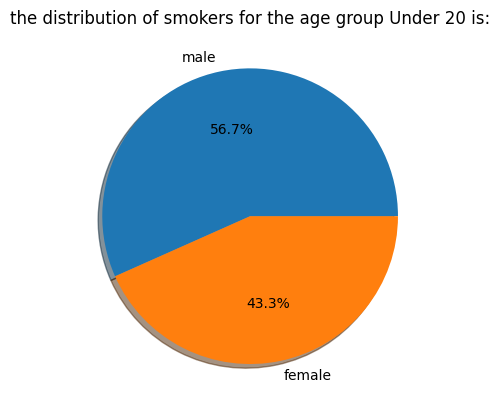

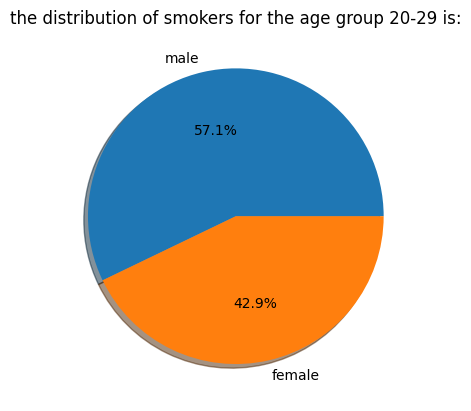

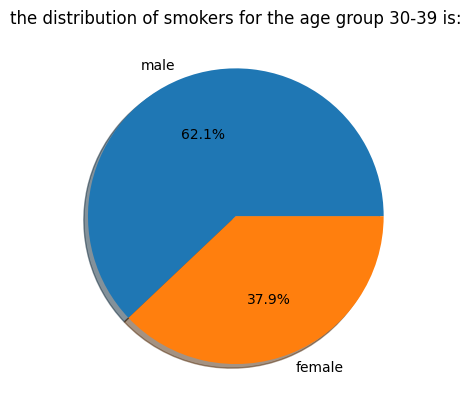

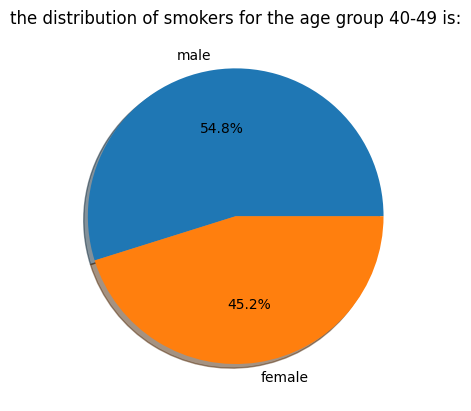

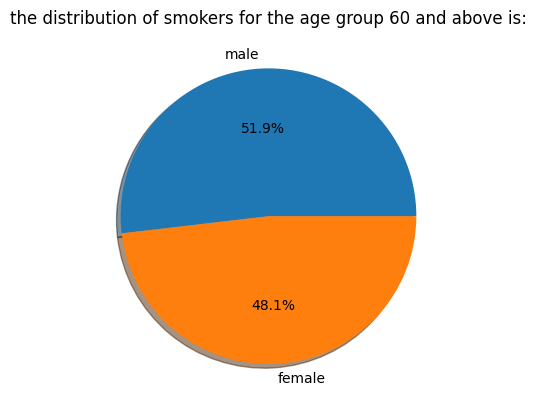

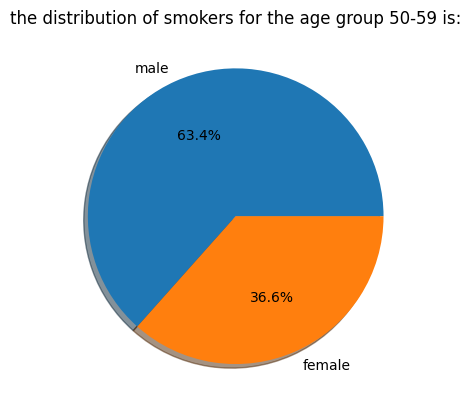

In [0]:
# Let us now explore the percentage of smokers and non smokers in each age group. From the below pie charts, the percentage of male smokers is always greater than the females in each age group. Specifically, in the age group between 30-39 and 50-59 have  highest male smokers of more than 60%.
smoking_data = new_pandas[new_pandas['smoker'] == 'yes']
for age_gp in new_pandas['age_group'].unique():
    age_smoke = smoking_data[smoking_data['age_group']==age_gp]
    count = age_smoke['sex'].value_counts()
    py.pie(count,labels = count.index,autopct='%1.1f%%',shadow = True)
    py.title("the distribution of smokers for the age group "+age_gp+" is:")
    py.show()

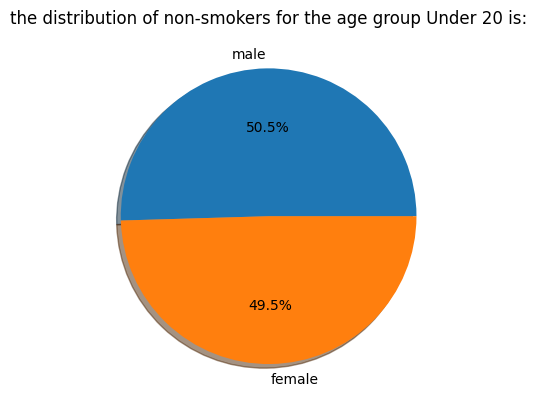

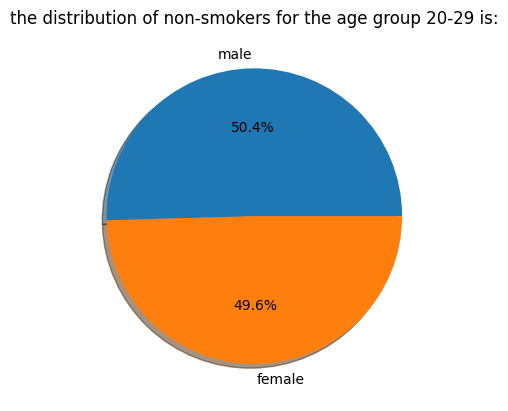

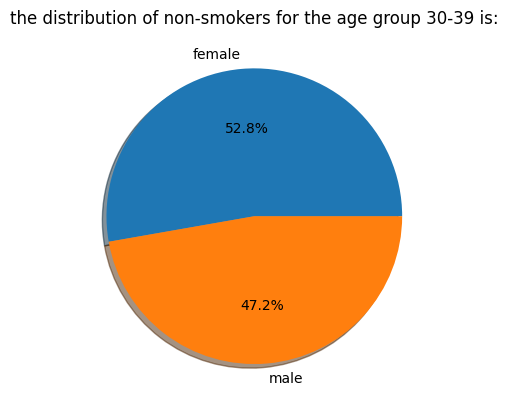

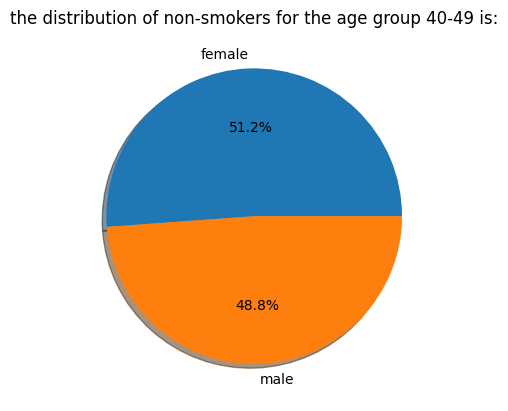

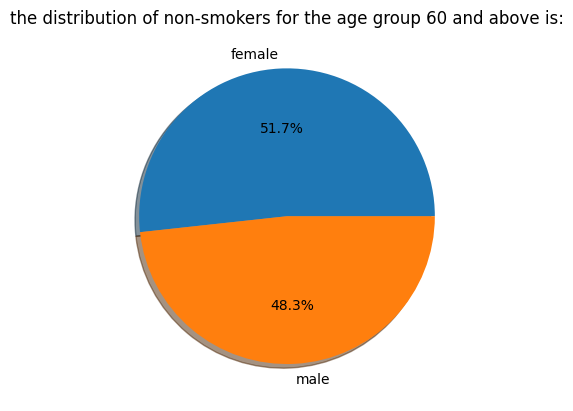

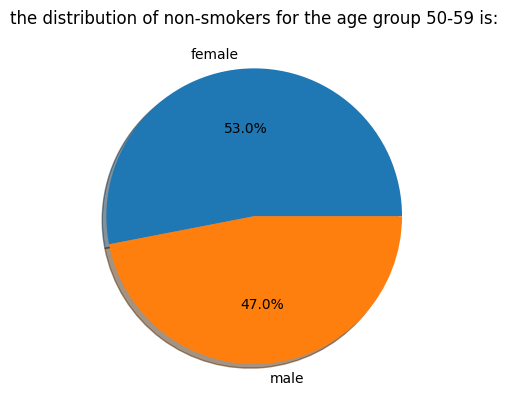

In [0]:
# When it comes to the non smokers, the percentage is almost equal for both the age groups.
smoking_data = new_pandas[new_pandas['smoker'] == 'no']
for age_gp in new_pandas['age_group'].unique():
    age_smoke = smoking_data[smoking_data['age_group']==age_gp]
    count = age_smoke['sex'].value_counts()
    py.pie(count,labels = count.index,autopct='%1.1f%%',shadow = True)
    py.title("the distribution of non-smokers for the age group "+age_gp+" is:")
    py.show()

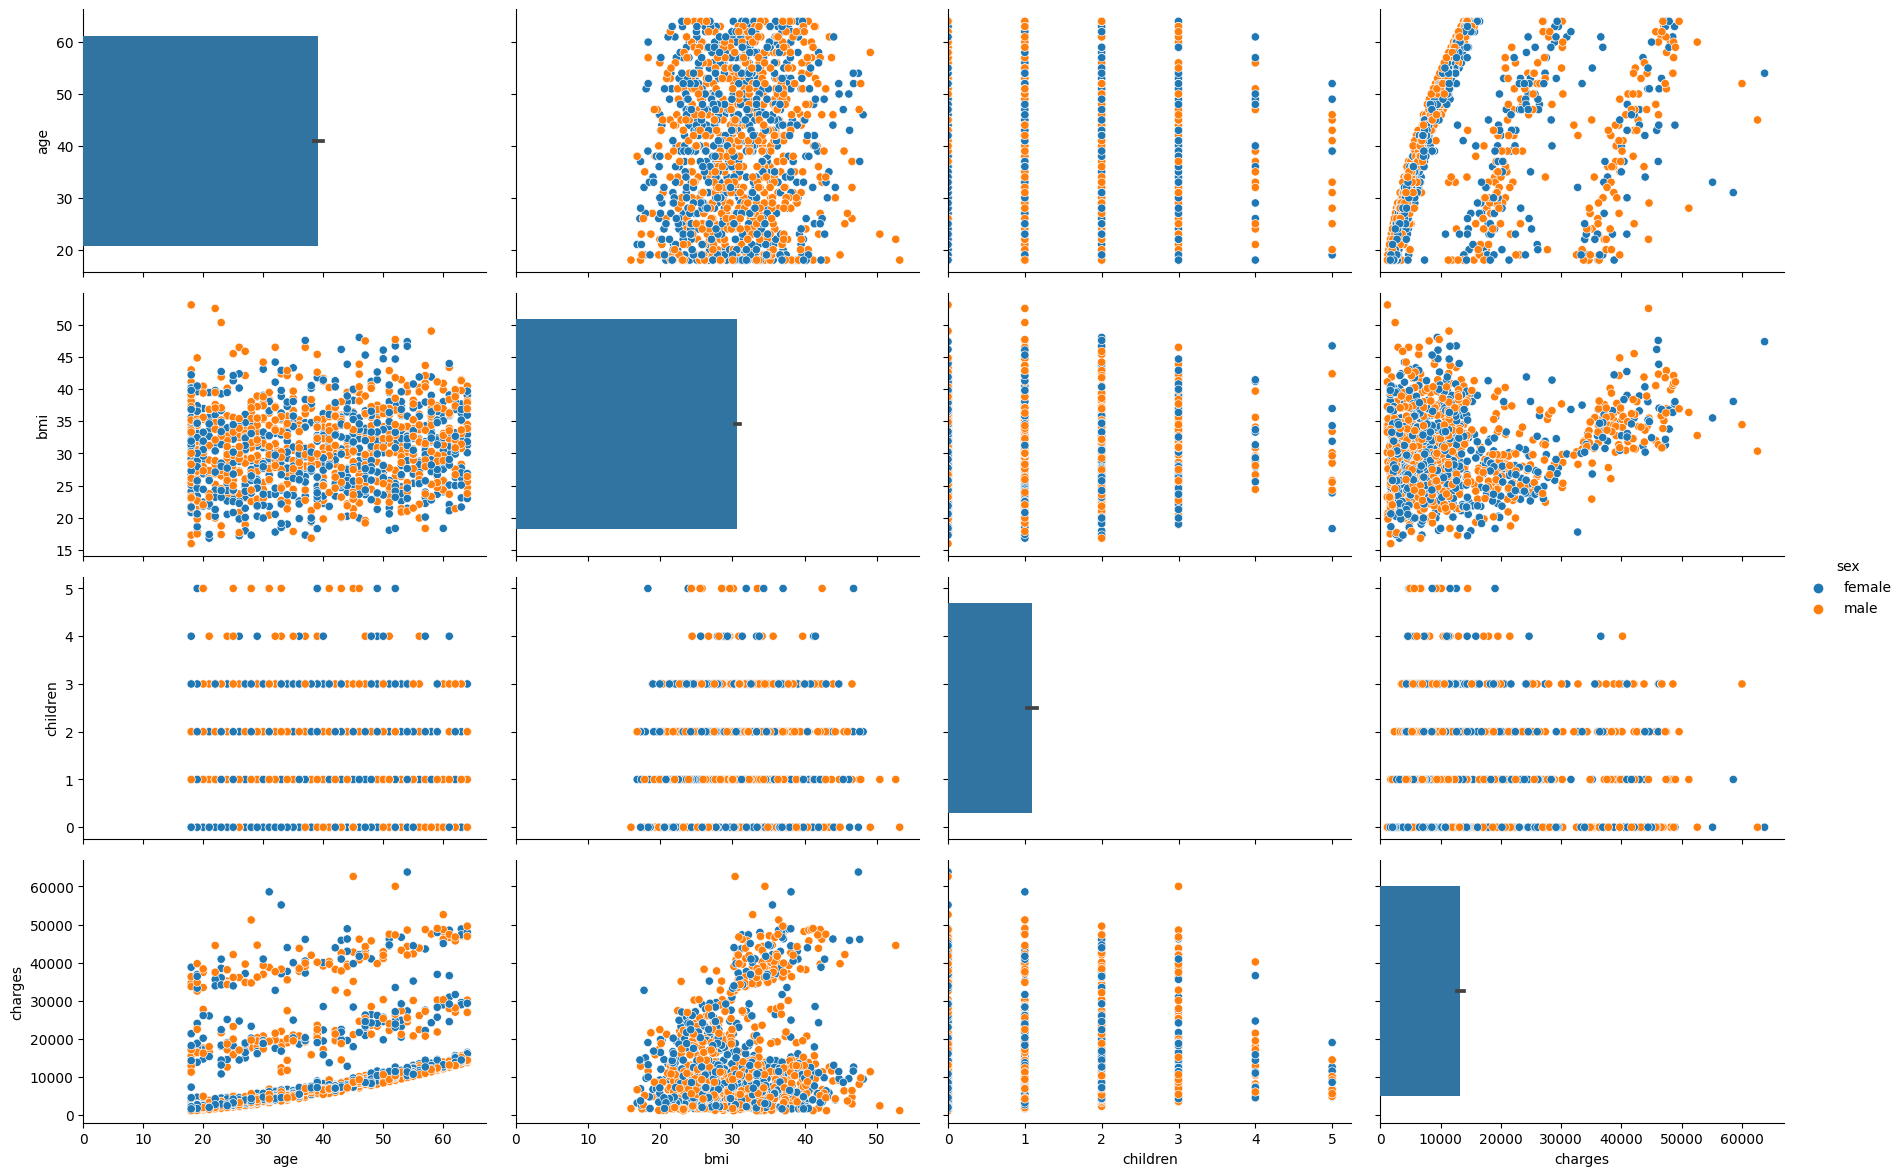

In [0]:
# The final data analysis, where we see the varying of different column values with respect to each other column.
charges_age_gender = sns.PairGrid(new_pandas,hue="sex",height=3,aspect=1.5)#,x_vars = 'age_group',y_vars = 'charges', hue='sex',height=5,aspect=2.5)
charges_age_gender.map_diag(sns.barplot)
charges_age_gender.map_offdiag(sns.scatterplot)
charges_age_gender.add_legend()
py.show()

In [0]:
+